# Continuous Control

---

In this notebook, we solve a Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

For **TRAINING** the agents, please execute the cells in **Sections 1, 2 and 3.**

For **RUNNING** the agents, please execute the cells in **Sections 1, 2 and ___4___.**

### 1. Start the Environment

We start by defining some hyperparameters:

In [1]:
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Now we configure the Jupyter environment and import the necessary packages. If the code cell below returns an error, please revisit the installation instructions in the project [README.md](https://github.com/hullmann/continuouscontrol-DDPG/blob/master/README.md).

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np

from IPython.display import clear_output

import torch

import time
from ddpg_agentx import OUNoise
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from ddpg_agentx import Agent
from ddpg_agentx import ReplayBuffer
from ddpg_agentx import MultiagentWrapper

Next, we start the Unity environment!  **_Before running the code cell below_**, please change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"Reacher.app"`
- **Windows** (x86): `"Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86_64): `"Reacher_Linux/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of the agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

The cell below will output some information about the environment and set relevant variables like `action_size` and `state_size`.

In [4]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3.  Training the agents

In the next code cell, we train the twenty agents.

Please note that they share a common `replaybuffer` that we initialize at the beginning of the cell. This will help them to learn faster. We could also think about sharing the network weights like in A2C and A3C algorithms, but in fact the performance was satisfactory without any weight sharing.

The environment is solved if we receive an average reward of more than +30 in 100 episodes. This is already achieved after the first 100 episodes as the average reward quickly rises to almost +40, see the reward plot for the twenty agents in the cell output.

After each episode, the model weights are being saved, so that you can stop training anytime and then run the agents based on the last model weights. The model weights contained in the repository have been trained in 100 episodes.

In [5]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 512        # minibatch size
UPDATE_INTERVAL = 4    # The number of time steps after which the agents are retrained
UPDATE_STEPS = 1       # The number of minibatches that are used for a retraining of the agents
NOISE_LEVEL=0.7
NOISE_DECAY=0.9999
RANDOM_SEED=3
NUM_AGENTS=2
SOLUTION_THRESHOLD=0.5

Episode 1	Average Score: 0.00	Score: 0.00	Noise Level: 0.70Environment solved! Saving agent weights
Episode 2	Average Score: 0.00	Score: 0.00	Noise Level: 0.70Environment solved! Saving agent weights
Episode 3	Average Score: 0.00	Score: 0.00	Noise Level: 0.70Environment solved! Saving agent weights
Episode 4	Average Score: 0.00	Score: 0.00	Noise Level: 0.70Environment solved! Saving agent weights
Episode 5	Average Score: 0.00	Score: 0.00	Noise Level: 0.70Environment solved! Saving agent weights
Episode 6	Average Score: 0.00	Score: 0.00	Noise Level: 0.70Environment solved! Saving agent weights
Episode 7	Average Score: 0.00	Score: 0.00	Noise Level: 0.70Environment solved! Saving agent weights
Episode 8	Average Score: 0.00	Score: 0.00	Noise Level: 0.70Environment solved! Saving agent weights
Episode 9	Average Score: 0.00	Score: 0.00	Noise Level: 0.70Environment solved! Saving agent weights
Episode 10	Average Score: 0.00	Score: 0.00	Noise Level: 0.70Environment solved! Saving agent weights

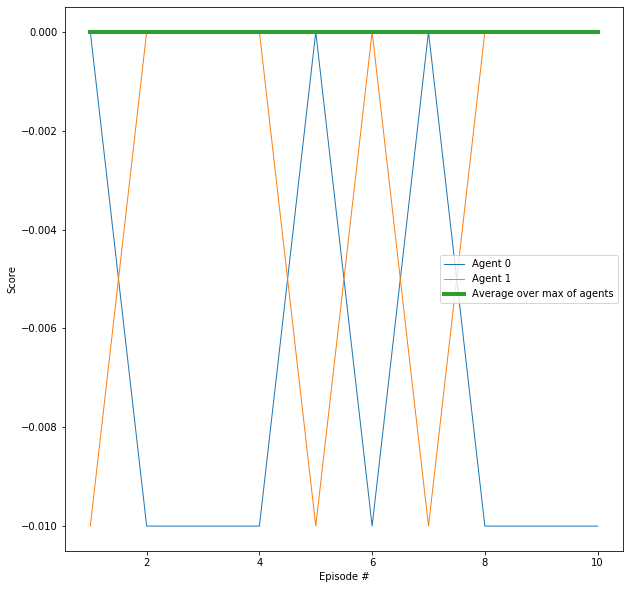

In [12]:
replaybuffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, RANDOM_SEED)

agents = MultiagentWrapper(RANDOM_SEED, BATCH_SIZE, replaybuffer)

def ddpg(n_episodes=2000, noise_level=NOISE_LEVEL, noise_decay=NOISE_DECAY):
    total_t = 0
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations
        for agent in agents.agents:
            agent.reset()
        
        scores_agents = np.zeros(NUM_AGENTS)
        for t in range(0, 1000):
            total_t += 1
            actions = agents.act(states, noise_level)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished

            scores_agents += np.array(env_info.rewards)
            replaybuffer.add(states, actions, rewards, next_states, dones)
            
            if total_t%UPDATE_INTERVAL==0:
                for _ in range(0, UPDATE_STEPS):
                    agents.learn()

            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break

        scores_deque.append(np.max(scores_agents)) # as discussed maximum of both agents
        scores.append(np.concatenate((scores_agents, (np.mean(scores_deque),))))
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tNoise Level: {:.2f}'.format(i_episode, np.mean(scores_deque), scores_deque[-1], noise_level))
        else:
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tNoise Level: {:.2f}'.format(i_episode, np.mean(scores_deque), scores_deque[-1], noise_level), end="")
            
        noise_level *= noise_decay

        if np.mean(scores_deque) >= SOLUTION_THRESHOLD or True:
            print('Environment solved! Saving agent weights')
            for agentNr in range(0, NUM_AGENTS):
                torch.save(agents.agents[agentNr].actor_local.state_dict(), 'model_weights/checkpoint_actor_{0}.pth'.format(agentNr))
                torch.save(agents.agents[agentNr].critic_local.state_dict(), 'model_weights/checkpoint_critic_{0}.pth'.format(agentNr))

    return scores

scores = ddpg(n_episodes=10)

fig, ax = plt.subplots(1,1,figsize=(10,10))
for agentNr in range(0, NUM_AGENTS):
    plt.plot(np.arange(1, len(scores)+1), [score[agentNr] for score in scores], label='Agent {}'.format(agentNr), linewidth=1)
plt.plot(np.arange(1, len(scores)+1), [score[NUM_AGENTS] for score in scores], label='Average over max of agents', linewidth=4)
plt.ylabel('Score')
plt.xlabel('Episode #')
ax.legend()
plt.show()

In [ ]:
%debug


In [ ]:
%debug

### 4. Running the agents

Now we can finally run the agents. If you experience problems with the Unity environment, reset the IPython kernel and execute the cells from the beginning -- without the training step, of course. The following cell reads in the model weights that have been written to the disk lastly.

You can observe the agents in the Unity window. Please note that it is now in full size as opposed to the training step, because we set `train_mode=False` in the call to `env.reset`. Also, when calling the `act` functions of the agents, we set `add_noise=False`, because this is only helpful when training the agents (think of the similarity to Dropout layers that are only active during training).

In [ ]:
replaybuffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, 13)

agents = [ Agent(state_size=state_size, action_size=action_size, random_seed=(13+seed), memory=replaybuffer) for seed in range(0, num_agents) ]

for agentNr in range(0, num_agents):
    agents[agentNr].actor_local.load_state_dict(torch.load('model_weights/checkpoint_actor_{0}.pth'.format(agentNr)))
    agents[agentNr].critic_local.load_state_dict(torch.load('model_weights/checkpoint_critic_{0}.pth'.format(agentNr)))

def run_ddpg():
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations
    for agent in agents:
        agent.reset()
    scores_agents = np.zeros(num_agents)
    for episode in range(0, 10):
        for t in range(0, 2000):
            actions = np.array([ agents[agentNr].act(states[agentNr, :][None, :], add_noise=True).flatten() for agentNr in range(0, num_agents)])
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores_agents += np.array(env_info.rewards)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
            time.sleep(0.1)

    print("The agents got the following scores: ", scores_agents)
    print("(mean = {0})".format(np.mean(scores_agents)))
    
run_ddpg()

In [ ]:
env.close() # Closes the environment

In [ ]:
for i in [0, 0]:
    print(i)

In [ ]:
torch.ones(3)[None, :
             ]